# Мастерская Yandex.Практикум. Проект: предсказание будущего стартапов.

## Описание проекта

Для анализа представлены псевдо-реальные данный о стартапах, функционировавших в период с 1970 по 2018 годы.    

**Основная задача проекта:** предсказать, какие из стартапов закроются**

**Предоставленные данные:** 
- ***kaggle_startups_train_01.csv:*** информация о 53к стартапах, которые будут использоваться в качестве обучающих данных.
- ***kaggle_startups_test_01.csv:*** информация о 13к стартапа, которые будут использоваться в качестве тестовых данных.
- ***kaggle_startups_sample_submit_01.csv:*** файл с примером предсказаний в правильном формате для загрузки на платформу kaggle

**Описание полей данных:**
- `name` - название стартапа;   
- `category_list` - список категорий, к которым относится стартап;   
- `funding_total_usd` - общая сумма финансирования в USD;   
- `status` - статус стартапа (закрыт или действующий);    
- `country_code` - код страны;   
- `state_code` - код штата;
- `region` - регион;
- `city` - город;
- `funding_rounds` - количество раундов финансирования;
- `founded_at` - дата основания;
- `first_funding_at` - дата первого раунда финансирования;
- `last_funding_at` - дата последнего раунда финансирования;
- `closed_at` - дата закрытия стартапа (если применимо);
- `lifetime` - время существования стартапа в днях.
    
**Ход исследования:**
* провести предобработку и исследовательский анализ данных;
* разработать новые синтетические признаки;
* проверить признаки на мультиколлинеарность и отобрать наиболее подходящие входные признаки для обучения модели;
* обучить несколько моделей и выбрать из них наиболее точную;
* оценить качество предсказания лучшей модели.

## Импорт библиотек

In [4]:
!pip install phik -q
!pip install --upgrade scipy scikit-learn jupyter
!pip install shap

Looking in indexes: https://pypi.org/simple, https://****@pypi.fury.io/babbel/
Looking in indexes: https://pypi.org/simple, https://****@pypi.fury.io/babbel/


In [5]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://****@pypi.fury.io/babbel/


In [6]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://****@pypi.fury.io/babbel/


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, RandomizedSearchCV, 
                                     GridSearchCV, cross_val_score)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (f1_score, r2_score, mean_absolute_error, mean_squared_error, 
                             accuracy_score, recall_score, precision_score, 
                             confusion_matrix, roc_auc_score, make_scorer, precision_recall_curve)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from phik.report import plot_correlation_matrix
from phik import report

import shap

import category_encoders as ce

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._encoders")

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [9]:
# показывать все колонки датафреймов
pd.set_option('display.max_columns', None)
RANDOM_STATE = 42

## Добавление функций

In [11]:
# функция для вывода общей информации о датафрейме
def df_review(df):
    display(df.head())
    df.info()
    display(df.describe())

In [12]:
def count_cats(str, sep='|'):
    try: return len(str.split(sep))
    except: return 0

In [13]:
def normalized_status_bar_chart(df, feature, target, colors=['pink', 'cyan']):
    """
    Создает нормализованную бар-диаграмму для заданного признака и целевой переменной.

    Параметры:
    df: исходный датафрейм, содержащий данные.
    feature: название признака, для которого строится диаграмма.
    target: название целевой переменной, по которой группируются данные.
    colors: список цветов для каждой категории целевой переменной (по умолчанию ['pink', 'cyan']).
    """
    count_df = df.groupby([target, feature]).size().reset_index(name='counts')

    total_counts = count_df.groupby(target)['counts'].transform('sum')

    count_df['normalized_count'] = count_df['counts'] / total_counts

    plt.figure(figsize=(8, 4))
    bar_chart = sns.barplot(x=feature, y='normalized_count', hue=target, data=count_df, dodge=True, palette=colors)
    plt.title('Нормализованная бар-диаграмма признака {} по признаку {}'.format(feature, target))
    plt.xlabel('Количество {}'. format(feature))
    plt.ylabel('Доля компаний')
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.show()

In [14]:
def select_model(name):
    '''
    Вычисляются оптимальные гиперпараметры для модели name.

    Параметры:
    name: название модели, для которой необходимо найти оптимальные гиперпараметры.

    Возвращает:
    tuple: кортеж, содержащий:
        - search.best_params_: лучшие гиперпараметры модели.
        - search.best_score_: лучший результат модели по метрике F1 на кросс-валидации.
        - cv_scores.mean(): среднее значение F1-меры на кросс-валидации.
        - cv_scores.std(): стандартное отклонение F1-меры на кросс-валидации.
        - best_threshold: лучший порог для F1-меры.
        - f1 (float): F1-мера на валидационном наборе данных.
    cv_scores: массив значений F1-меры на кросс-валидации.
    search.best_estimator_: модель с лучшими гиперпараметрами.
    '''
     
    search = RandomizedSearchCV(model_pipelines[name], param_grid[name], cv=5, scoring='f1', n_jobs=-1
                                , random_state=RANDOM_STATE)
    search.fit(X_train, y_train)
    
    cv_scores = cross_val_score(search, X_train, y_train, cv=5, scoring='f1')

    # Предсказание вероятностей
    y_probs = search.best_estimator_.predict_proba(X_validation)[:, 1]

    # Вычисление precision-recall кривой
    precision, recall, thresholds = precision_recall_curve(y_validation, y_probs)

    # Нахождение лучшего порога для F1-меры
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Предсказание с использованием лучшего порога
    y_pred = (y_probs >= best_threshold).astype(int)

    # Вычисление F1-меры
    f1 = round(f1_score(y_validation, y_pred), 3)

    my_tuple = (search.best_params_, round(search.best_score_, 3), round(cv_scores.mean(), 3),
               round(cv_scores.std(), 2), round(best_threshold, 3), f1) 
    
    return my_tuple, cv_scores, search.best_estimator_

## Загрузка и подготовка данных

In [16]:
# импорт полученных для анализа датафреймов
startups_status = pd.read_csv('kaggle_startups_sample_submit_28062024.csv', sep=',')
startups_test = pd.read_csv('kaggle_startups_test_28062024.csv', sep=',')
startups_train = pd.read_csv('kaggle_startups_train_28062024.csv', sep=',')

### Датасеты `startups_status` и `startups_test`

Посмотрим на тестовые данные и формат загрузки данных на Kaggle. 

In [19]:
df_review(startups_status)

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


,name,status
count,13125,13125
unique,13125,2
top,Crystalsol,operating
freq,1,6635


In [20]:
df_review(startups_test)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


### Обучающие данные `startups_train`

In [22]:
df_review(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


Всего в обучающей выборке 52 515 строк. В данных есть явные пропуски, займёмся ими позже. Сперва проверим наличие дубликатов в данных

In [24]:
duplicates_count = startups_train.duplicated().sum()
print(f"Количество дубликатов в 'startups_train': {duplicates_count}")

Количество дубликатов в 'startups_train': 0


In [25]:
name_duplicates = startups_train['name'].duplicated().sum()
print(f"Количество дублирующихся названий в 'startups_train': {name_duplicates}")

Количество дублирующихся названий в 'startups_train': 0


Явных дубликатов в данных не обнаружено.

## Предобработка данных

### Формат данных

Приведем данные в удобный для дальнейшей работы формат

In [30]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [31]:
startups_train['founded_at'] = startups_train['founded_at'].astype('datetime64[ns]')
startups_train['closed_at'] = startups_train['closed_at'].astype('datetime64[ns]')
startups_train['first_funding_at'] = startups_train['first_funding_at'].astype('datetime64[ns]')
startups_train['last_funding_at'] = startups_train['last_funding_at'].astype('datetime64[ns]')
startups_train['state_code'] = startups_train['state_code'].astype('str')

### Пропуски

In [33]:
startups_train.isnull().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code               0
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

Для удобства обработки данных заполним пропуски в `country_code`, `state_code`, `region`, `city` и `category_list` значением `'unkown'`. Присвоим стартапу без имени название 'NoName Startup'.

In [35]:
startups_train[['country_code', 'state_code', 'region', 'city']] = startups_train[['country_code', 'state_code', 'region', 'city']].fillna('unknown')

In [36]:
startups_train['name'].isnull().sum()

1

In [37]:
startups_train['name'].fillna('NoName Startup', inplace=True)

Для заполнения пропусков в `funding_total_usd` сначала посмотрим на распределение этого признака.

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
95%      6.800000e+07
99%      2.200000e+08
max      3.007950e+10
Name: funding_total_usd, dtype: float64

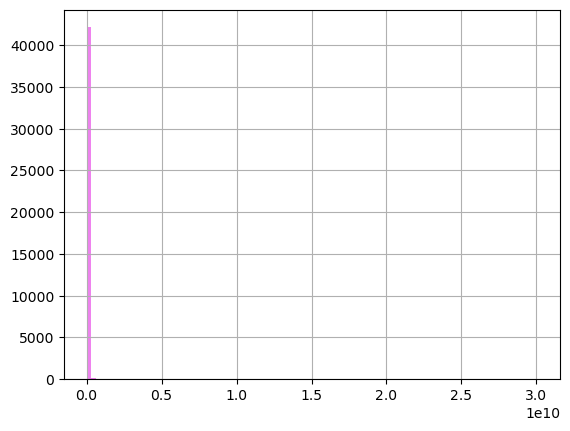

In [39]:
startups_train['funding_total_usd'].hist(bins=100, color='violet')
startups_train['funding_total_usd'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

Так как значения этого признака могут существенно отличаться по порядку величины, посмотрим на этот же признак, но в логарифмической шкале.

count    42447.000000
mean        14.367373
std          2.395149
min          0.693147
25%         12.724951
50%         14.508658
75%         16.118096
max         24.127110
Name: funding_total_usd, dtype: float64

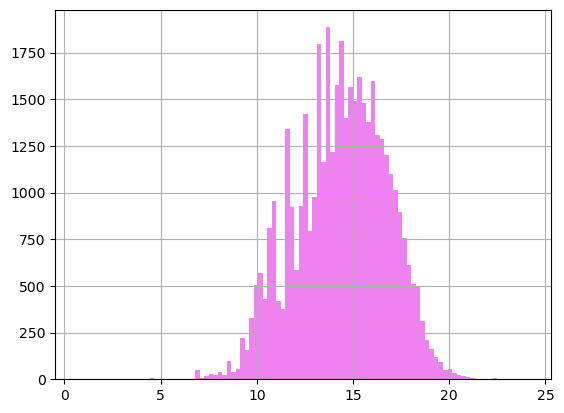

In [41]:
startups_train['funding_total_usd'].apply(np.log1p).hist(bins=100, color='violet')
startups_train['funding_total_usd'].apply(np.log1p).describe()

In [42]:
startups_train[startups_train['funding_total_usd'].apply(np.log1p) >= 24]
#startups_train = startups_train[startups_train['name'] != 'Verizon Communications']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
39186,Verizon Communications,Communications Infrastructure|Information Tech...,3.007950e+10,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,NaT


<Axes: xlabel='funding_rounds', ylabel='funding_total_usd'>

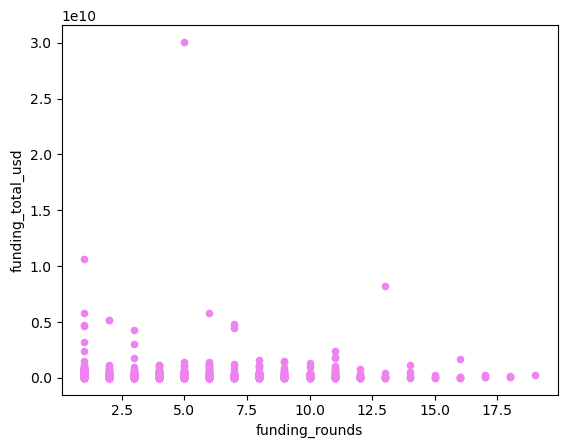

In [43]:
startups_train[['funding_total_usd', 'funding_rounds']].plot.scatter('funding_rounds', 'funding_total_usd', color='violet')

<Axes: xlabel='first_funding_at', ylabel='funding_total_usd'>

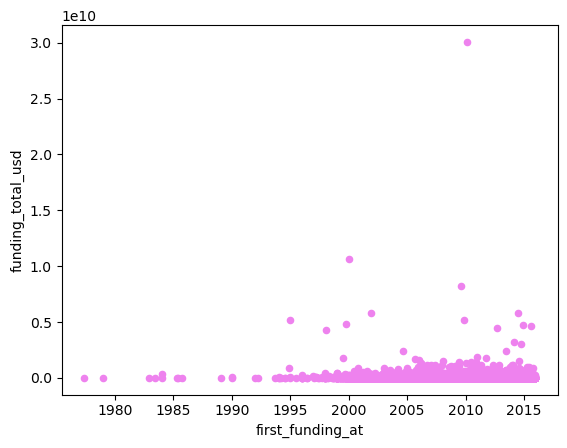

In [44]:
startups_train[['funding_total_usd', 'first_funding_at']].plot.scatter('first_funding_at', 'funding_total_usd', color='violet')

Пропуски в `fundings_total_usd` заменим средними значениями. Для большей точности расчитаем средние значения на основе количества раундов финансирования - в существующих данных мы можем посчитать медиану для любого количетсва раундов финансирования. Для года первого финансирования мы этого гарантировать не можем, тк есть "пропущенные" годы.

In [46]:
mean_values = startups_train.groupby(['funding_rounds'])['funding_total_usd'].median()

In [47]:
startups_train['funding_total_usd'] = startups_train.apply(
    lambda row: mean_values[row['funding_rounds']] if pd.isna(row['funding_total_usd']) else row['funding_total_usd'],
    axis=1
)

Гистограмма fundings_total_usd


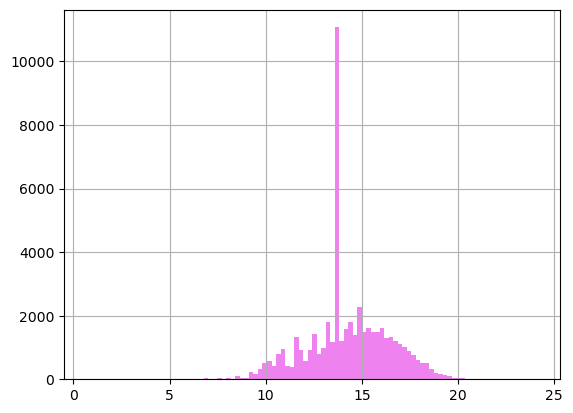

In [48]:
startups_train['funding_total_usd'].apply(np.log1p).hist(bins=100, color='violet')
print('Гистограмма fundings_total_usd')

На графике распределения появился характерный пик.

In [50]:
startups_train.isnull().sum()

name                     0
category_list         2465
funding_total_usd        0
status                   0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

Прежде, чем запонять пропуски в категориях, посмотрим на существующие категории.

In [52]:
print(startups_train['category_list'].unique())

['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']


Выделим список уникальных категорий.

In [54]:
all_cats = ''
for i in startups_train['category_list']:
    try: all_cats += i + '|'
    except TypeError: pass
unique_cats = set(all_cats.split('|'))
print(f'Количество уникальных категорий: {len(unique_cats)}')

Количество уникальных категорий: 855


In [55]:
categories = dict(zip(unique_cats, [0]*len(unique_cats)))
tmp = startups_train['category_list'].isnull()
for i in range(len(startups_train)):
    try: 
        for cat in list(categories.keys()):
            if cat in startups_train['category_list'][i].split('|'):
                categories[cat]+=1
    except: pass
        

Добавлять отдельный признак для принадлежности каждой из 855 категорий не целесообразно, поэтому посмотрим на топ категорий и добавим признак для пренадлежности к этим категориям.

In [57]:
df = pd.DataFrame(categories.items(), columns=['Category', 'N_startups'])
df.sort_values('N_startups', ascending=False).head(10)

,Category,N_startups
710,Software,7017
510,Mobile,4399
677,Biotechnology,3668
226,E-Commerce,3308
783,Curated Web,2407
134,Social Media,2284
454,Enterprise Software,2193
721,Advertising,1985
711,Health Care,1885
315,Games,1810


In [58]:
df.sort_values('N_startups').head(10)

,Category,N_startups
0,,0
676,Private Corrections,1
750,Quantitative Marketing,1
450,HDTV,1
443,TV Station,1
202,Labor Optimization,1
26,Early Stage IT,1
413,EDA Tools,1
403,Mothers,1
717,Startup Histrionics,1


Топ 10 наименее популярных категорий выведены для более общего понимания картины.

Запоним пропуски в прищнаке категорий значением `'unknown'`. Добавим новые признаки.

In [60]:
startups_train['category_list'] = startups_train['category_list'].fillna('unknown')
startups_train['is_software'] = startups_train['category_list'].str.contains('software', case=False).astype('int64')
startups_train['is_mobile'] = startups_train['category_list'].str.contains('mobile', case=False).astype('int64')
startups_train['is_biotech'] = startups_train['category_list'].str.contains('biotech', case=False).astype('int64')
startups_train['is_ecommerce'] = startups_train['category_list'].str.contains('e-commerce', case=False).astype('int64')
startups_train['is_tech'] = startups_train['category_list'].str.contains('tech', case=False).astype('int64')
startups_train['is_health'] = startups_train['category_list'].str.contains('health', case=False).astype('int64')
startups_train['is_web'] = startups_train['category_list'].str.contains('web', case=False).astype('int64')
startups_train['is_social_media'] = startups_train['category_list'].str.contains('social media', case=False).astype('int64')

In [61]:
startups_train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,is_software,is_mobile,is_biotech,is_ecommerce,is_tech,is_health,is_web,is_social_media
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0,0,0,0,0,0,0,0
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0,0,0,0,0,0,0,0
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0,0,1,0,1,0,0,0
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,nan,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,0,0,0,0,0,1,0,0
4,WireTough Cylinders,Manufacturing,860000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,860000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,0,0,0,0,0,0,0,0
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,0,0,0,0,0,0,0,0
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,1,0,0,0,0,0,0,0
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,0,0,0,0,0,0,0,0


### Дополнительные признаки

Добавим признак, отражающий количество категорий, к которым относится стартап. 

In [64]:
startups_train['n_cats'] = startups_train['category_list'].apply(count_cats)
startups_train.sort_values('n_cats', ascending=False)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,is_software,is_mobile,is_biotech,is_ecommerce,is_tech,is_health,is_web,is_social_media,n_cats
42849,Zealr,Analytics|Application Platforms|App Marketing|...,7500.0,operating,USA,CA,Ontario - Inland Empire,Yorba Linda,1,2015-01-20,2015-08-18,2015-08-18,NaT,1,1,0,0,1,0,1,1,40
25568,GlobeChat,Android|Apps|Chat|Education|Entertainment|Gene...,1000000.0,operating,USA,CA,"Orange County, California",San Juan Capistrano,1,2015-03-09,2015-03-09,2015-03-09,NaT,0,1,0,0,1,0,0,1,25
15783,Kony,Android|Application Platforms|App Marketing|Ba...,103400000.0,operating,USA,FL,Orlando,Orlando,6,2007-01-01,2011-01-18,2015-05-12,NaT,1,1,0,0,0,1,0,0,23
3094,Hire.Ventures,Ad Targeting|Assisitive Technology|Career Mana...,100000.0,operating,USA,CA,SF Bay Area,San Francisco,1,2015-01-01,2015-01-01,2015-01-01,NaT,0,0,0,0,1,0,0,1,23
44078,AlterGeo,Advertising|Android|Apps|Discounts|Gps|Indoor ...,11000000.0,operating,RUS,48,Moscow,Moscow,2,2008-01-01,2009-01-01,2011-06-09,NaT,0,1,0,0,1,0,0,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33842,Toppr,Education,14200000.0,operating,IND,16,Mumbai,Mumbai,4,2013-01-01,2013-05-09,2015-10-30,NaT,0,0,0,0,0,0,0,0,1
33841,GridX,Software,500000.0,operating,USA,CA,SF Bay Area,Sunnyvale,1,2010-01-01,2013-04-15,2013-04-15,NaT,1,0,0,0,0,0,0,0,1
15378,Audience.fm,Music,860000.0,operating,USA,CA,SF Bay Area,San Francisco,1,2013-01-01,2013-05-01,2013-05-01,NaT,0,0,0,0,0,0,0,0,1
15380,Green Horse Games,Games,2927171.0,operating,ROM,10,Bucharest,Bucharest,2,2013-05-30,2013-06-10,2015-01-20,NaT,0,0,0,0,0,0,0,0,1


Так как в тестовый датафрейм явно включена информация о времени существования стартапа, добавим аналогичное поле в тренировочные данные.

In [66]:
startups_train['closed_at_filled'] = startups_train['closed_at'].fillna(pd.to_datetime('2018-01-01'))
startups_train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,is_software,is_mobile,is_biotech,is_ecommerce,is_tech,is_health,is_web,is_social_media,n_cats,closed_at_filled
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0,0,0,0,0,0,0,0,2,2018-01-01
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0,0,0,0,0,0,0,0,3,2018-01-01
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0,0,1,0,1,0,0,0,1,2018-01-01
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,nan,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,0,0,0,0,0,1,0,0,1,2018-01-01
4,WireTough Cylinders,Manufacturing,860000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,860000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,0,0,0,0,0,0,0,0,1,2018-01-01
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,1,0,0,0,0,0,0,0,3,2018-01-01
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01


In [67]:
startups_train['lifetime'] = (startups_train['closed_at_filled'] - startups_train['founded_at']).dt.days
startups_train['lifetime_months'] = startups_train['lifetime']/30.5

In [68]:
startups_train['log_funds'] = startups_train['funding_total_usd'].apply(np.log1p)

In [69]:
startups_train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,is_software,is_mobile,is_biotech,is_ecommerce,is_tech,is_health,is_web,is_social_media,n_cats,closed_at_filled,lifetime,lifetime_months,log_funds
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0,0,0,0,0,0,0,0,2,2018-01-01,2998,98.295082,13.627525
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0,0,0,0,0,0,0,0,3,2018-01-01,4748,155.672131,17.575198
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0,0,1,0,1,0,0,0,1,2018-01-01,4383,143.704918,17.383814
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,nan,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,0,0,0,0,0,1,0,0,1,2018-01-01,5114,167.672131,16.917853
4,WireTough Cylinders,Manufacturing,860000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01,2791,91.508197,13.664689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,860000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01,2192,71.868852,13.664689
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,0,0,0,0,0,0,0,0,1,2018-01-01,1590,52.131148,13.122365
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,1,0,0,0,0,0,0,0,3,2018-01-01,2741,89.868852,10.819798
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01,7336,240.524590,16.380460


Добавим аналогичные признаки в тестовые данные и заполним пропуски.

In [71]:
startups_test['first_funding_at'] = startups_test['first_funding_at'].astype('datetime64[ns]')
startups_test['last_funding_at'] = startups_test['last_funding_at'].astype('datetime64[ns]')
startups_test['state_code'] = startups_test['state_code'].astype('str')

In [72]:
startups_test.isnull().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code              0
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [73]:
startups_test[['country_code', 'state_code', 'region', 'city', 'category_list']] = startups_test[['country_code'\
                                                                                        , 'state_code', 'region', 'city', 'category_list']]\
                                                                                        .fillna('unknown')

In [74]:
mean_values = startups_test.groupby(['funding_rounds'])['funding_total_usd'].median()

In [75]:
startups_test['funding_total_usd'] = startups_test.apply(
    lambda row: mean_values[row['funding_rounds']] if pd.isna(row['funding_total_usd']) else row['funding_total_usd'],
    axis=1
)

In [76]:
startups_test.isnull().sum()

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

In [77]:
startups_test['n_cats'] = startups_test['category_list'].apply(count_cats)
startups_test['category_list'] = startups_test['category_list'].fillna('unknown')
startups_test['is_software'] = startups_test['category_list'].str.contains('software', case=False).astype('int64')
startups_test['is_mobile'] = startups_test['category_list'].str.contains('mobile', case=False).astype('int64')
startups_test['is_biotech'] = startups_test['category_list'].str.contains('biotech', case=False).astype('int64')
startups_test['is_ecommerce'] = startups_test['category_list'].str.contains('e-commerce', case=False).astype('int64')
startups_test['is_tech'] = startups_test['category_list'].str.contains('tech', case=False).astype('int64')
startups_test['is_health'] = startups_test['category_list'].str.contains('health', case=False).astype('int64')
startups_test['is_web'] = startups_test['category_list'].str.contains('web', case=False).astype('int64')
startups_test['is_social_media'] = startups_test['category_list'].str.contains('social media', case=False).astype('int64')

## Анализ тренировочных и тестовых данных

Проведем базовый анализ тренировочных и тестовых данных.

<Axes: >

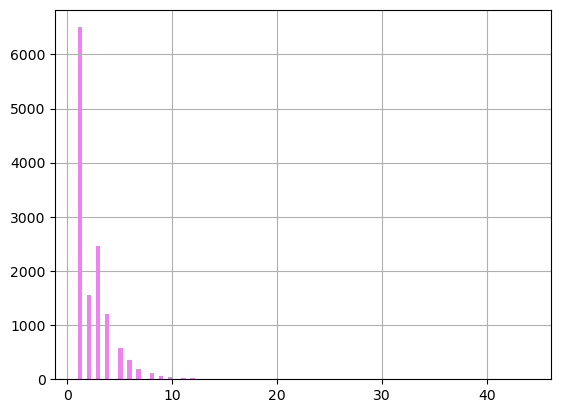

In [80]:
startups_test['n_cats'].hist(bins=100, color='violet')

<Axes: >

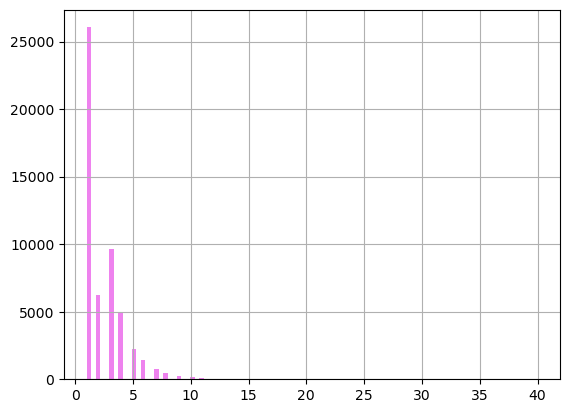

In [81]:
startups_train['n_cats'].hist(bins=100, color='violet')

<Axes: xlabel='status'>

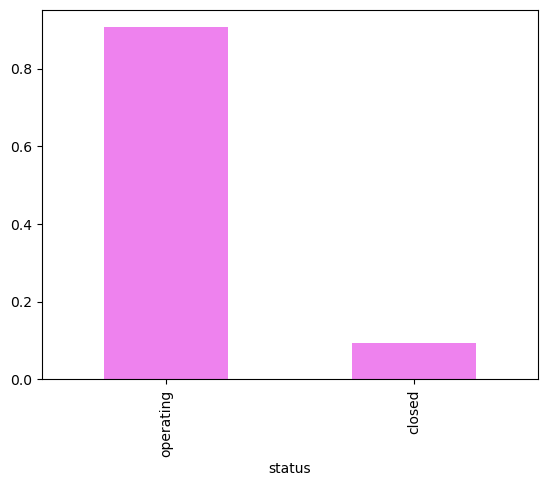

In [82]:
startups_train['status'].value_counts(normalize=True).plot(kind='bar', color='violet')

Только около 10% стартапов в тренировочных данных имеют статус 'closed'. Выборка не сбалансирована.

funding_total_usd 
 count    5.251600e+04
mean     1.497812e+07
std      1.683613e+08
min      1.000000e+00
25%      5.297212e+05
50%      1.021239e+06
75%      7.000000e+06
max      3.007950e+10
Name: funding_total_usd, dtype: float64 

funding_rounds 
 count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64 

is_software 
 count    52516.000000
mean         0.195236
std          0.396386
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_software, dtype: float64 

is_mobile 
 count    52516.000000
mean         0.100826
std          0.301102
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_mobile, dtype: float64 

is_biotech 
 count    52516.000000
mean         0.069864
std          0.254921
min

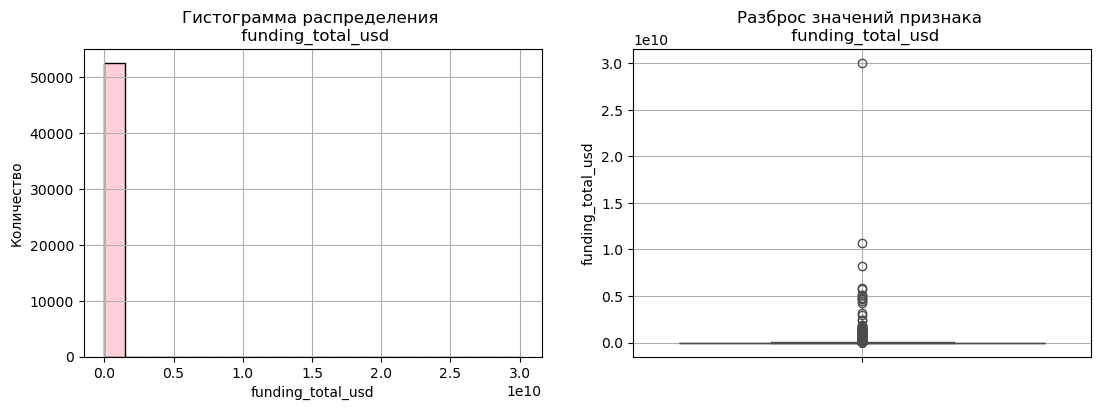

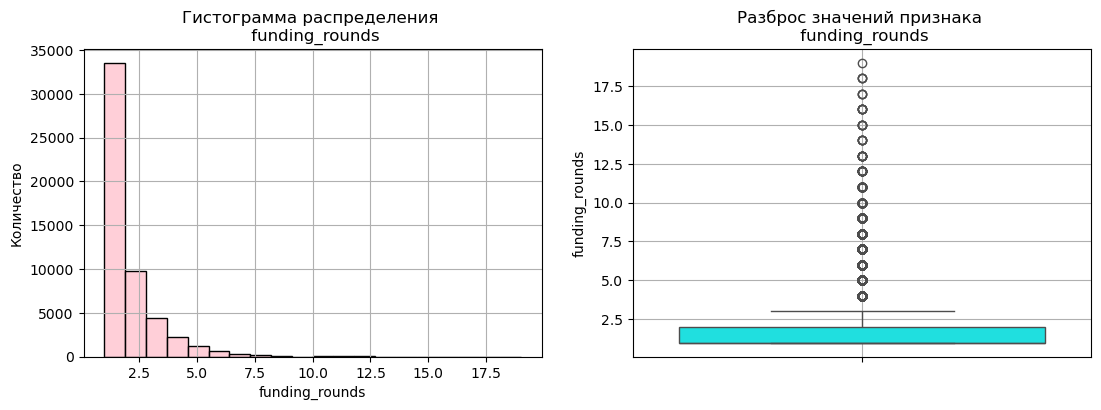

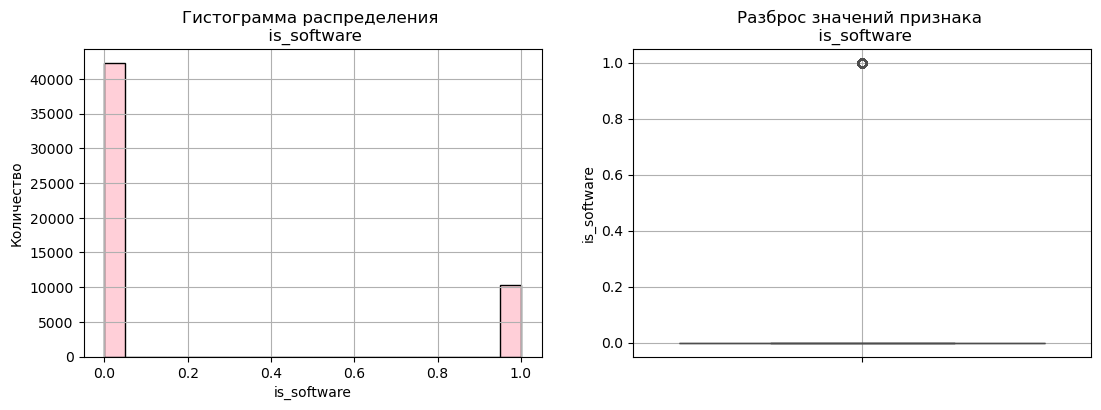

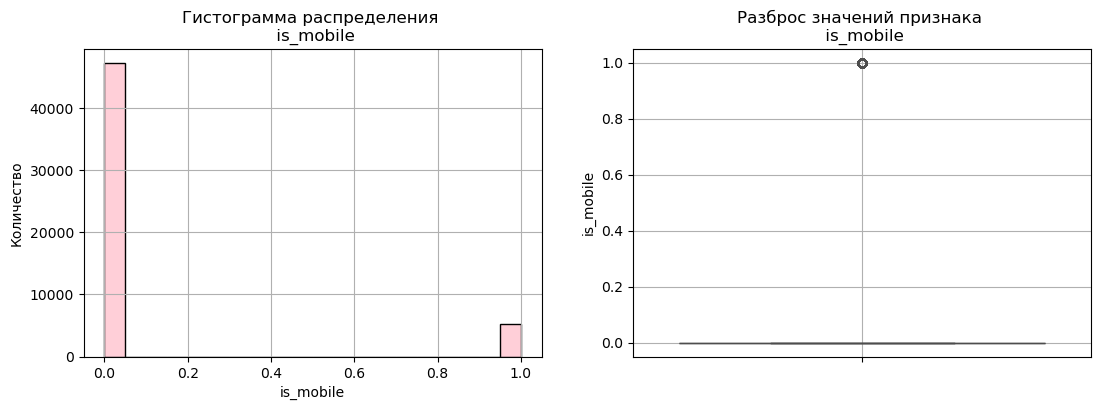

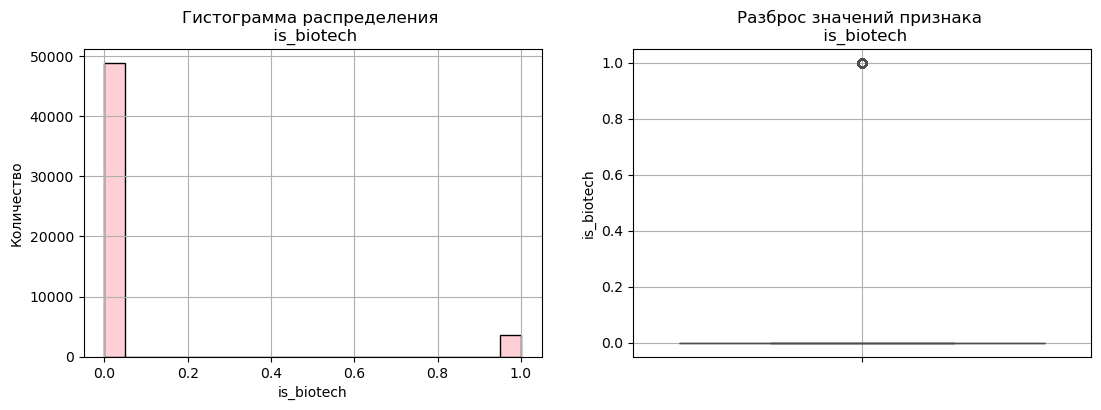

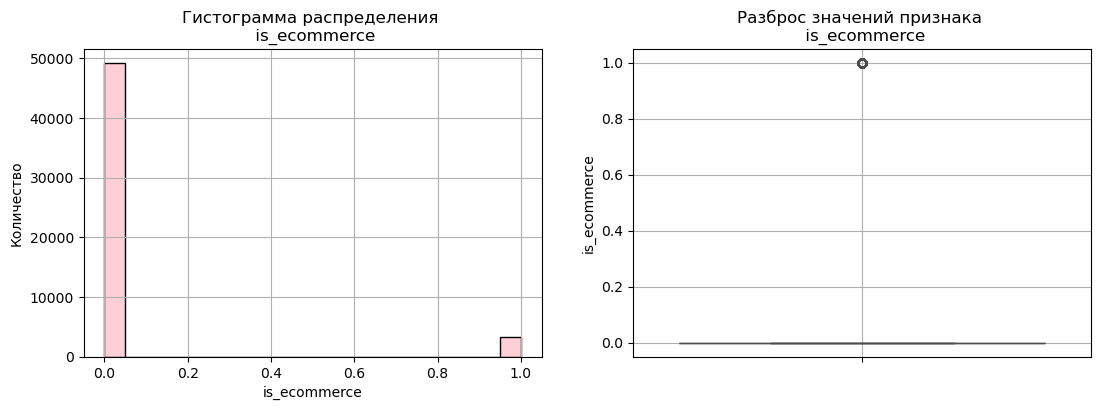

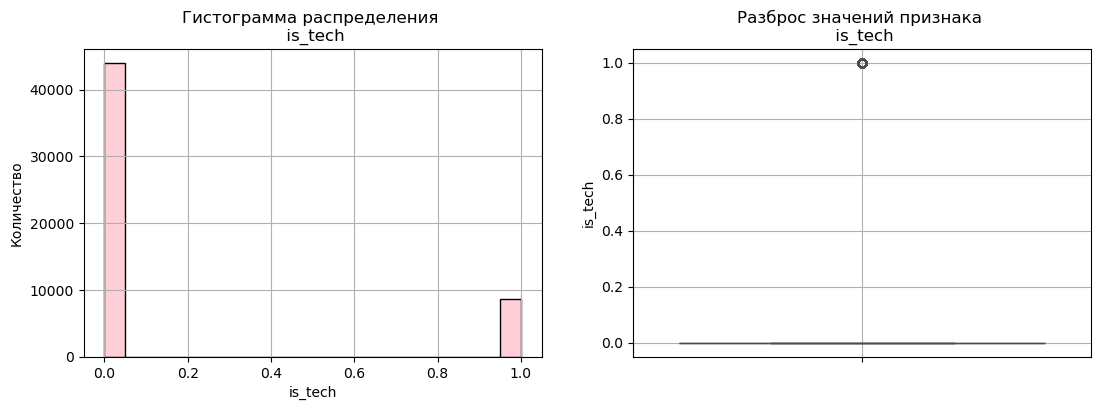

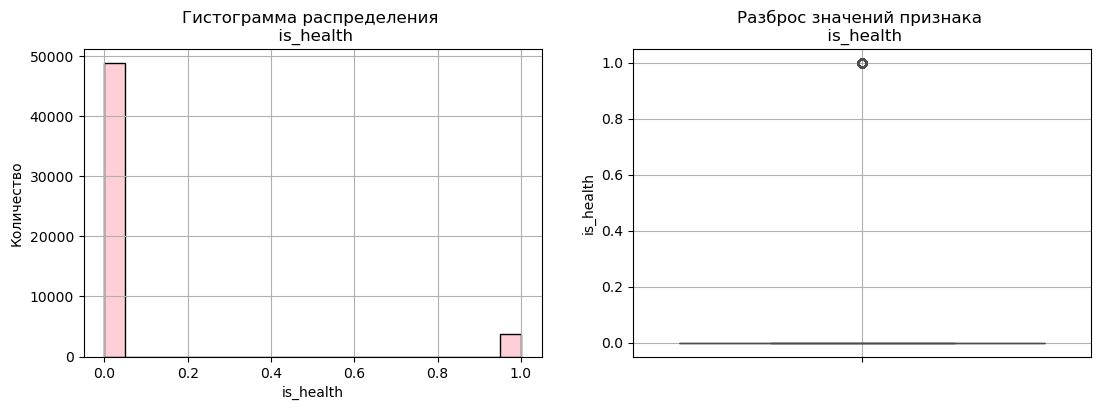

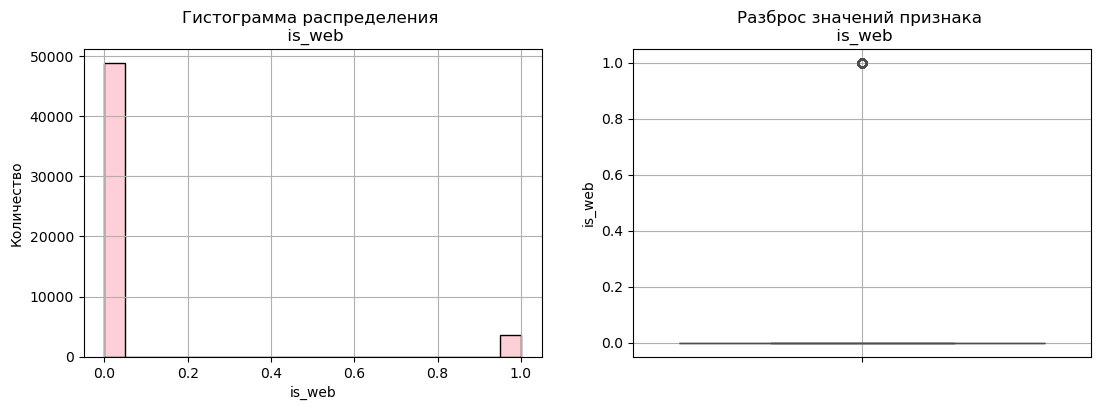

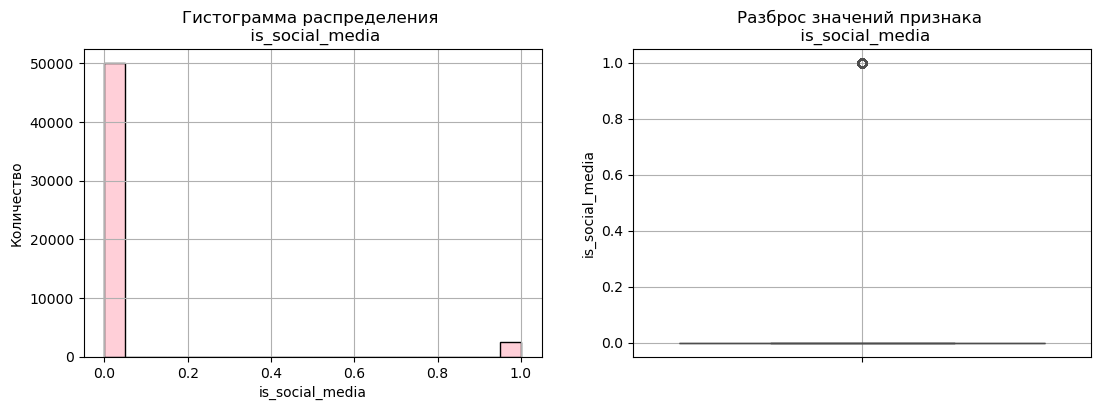

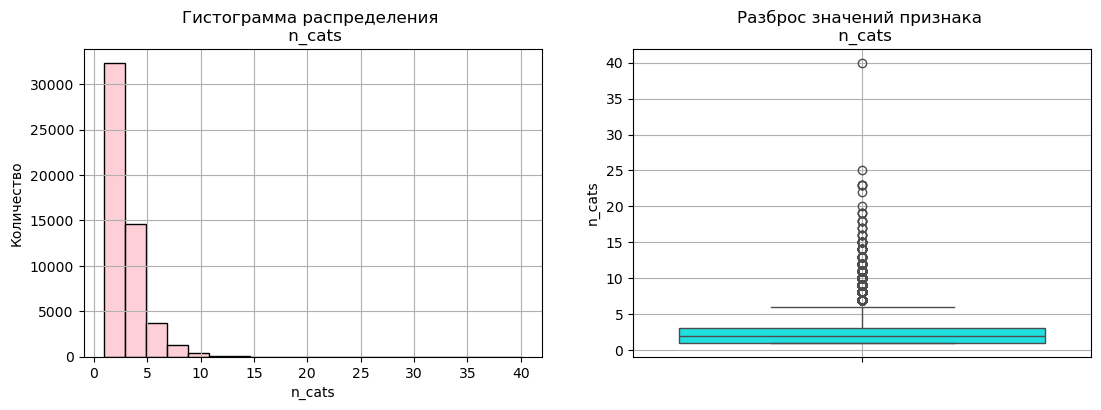

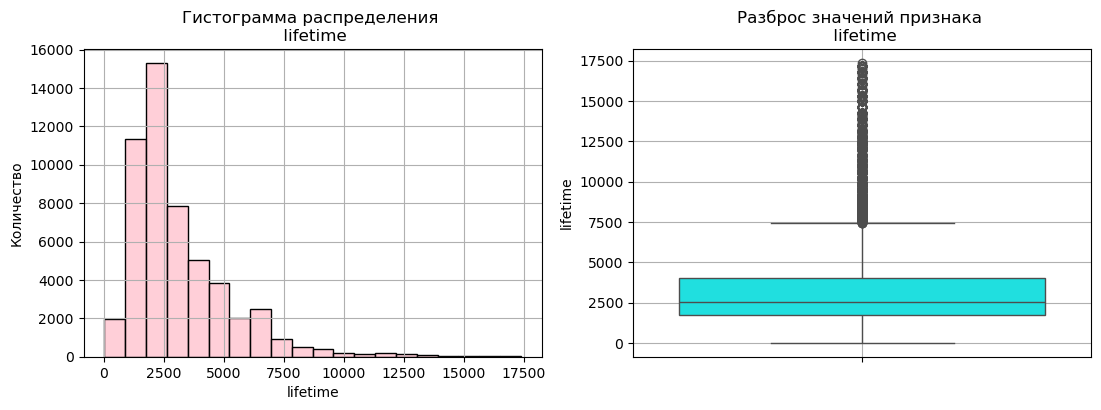

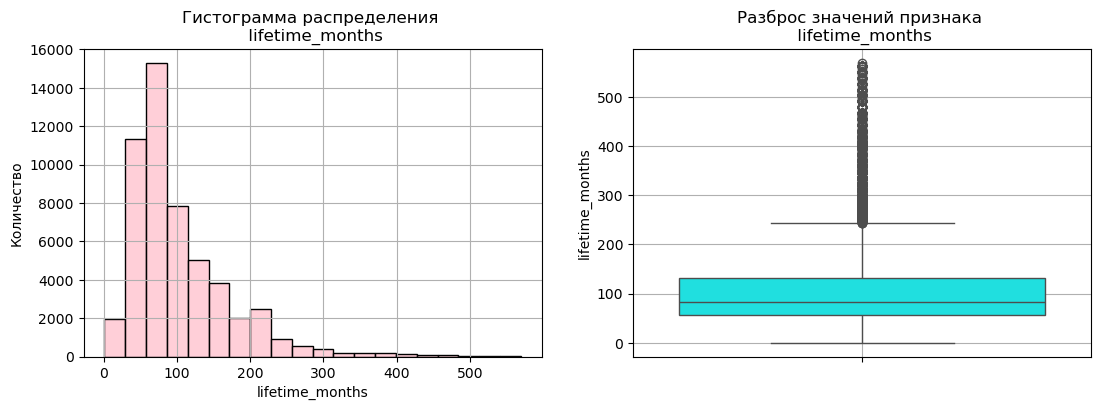

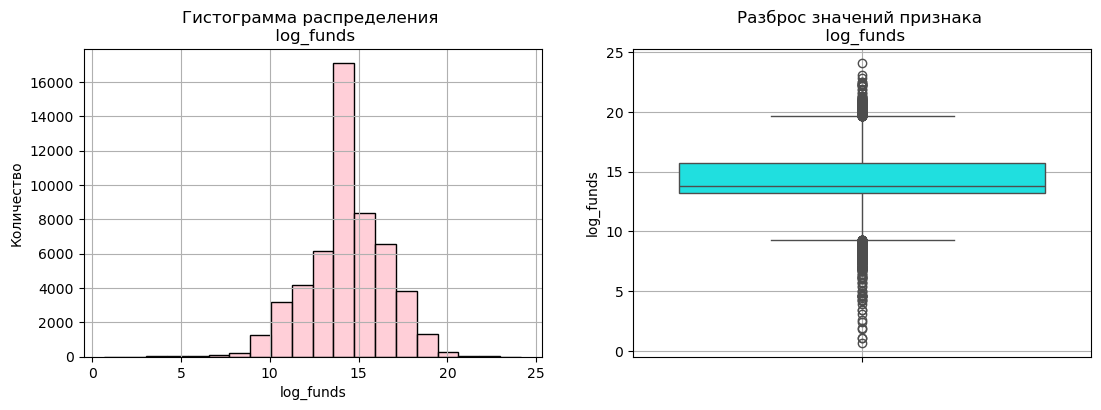

In [84]:
num_cols = startups_train.select_dtypes(include = ['int', 'float']).columns
for col in num_cols:
    print(col, '\n', startups_train[col].describe(), '\n')
    fix, ax = plt.subplots(1, 2, figsize=(13, 4))
    sns.histplot(startups_train, x=col, ax=ax[0], bins = 20, color='pink') 
    sns.boxplot(data = startups_train[col], ax=ax[1], color='cyan')
    ax[0].grid()
    ax[1].grid()
    ax[0].set(xlabel=col) 
    ax[0].set(ylabel='Количество') 
    ax[0].set_title(f'Гистограмма распределения \n {col}') 
    ax[1].set_title(f'Разброс значений признака \n {col}')

Графики распределения остальных признаков не указывают на очевидные выбросы в данных.

Сопоставим некоторые параметры для закрывшихся и функционирующих стартапов.

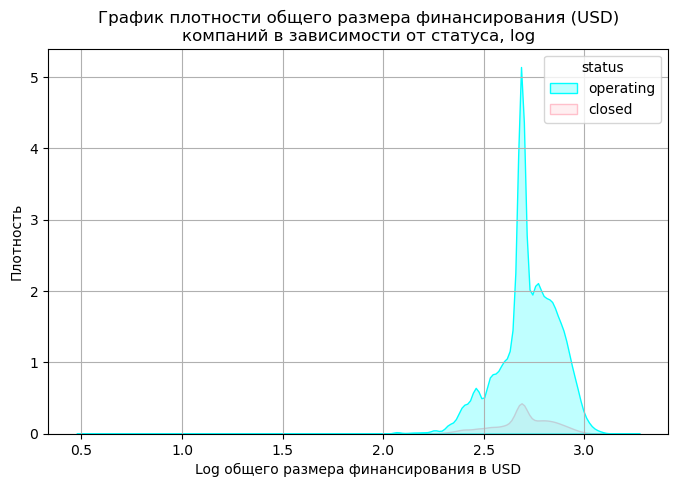

In [87]:
plt.figure(figsize=(8, 5))

sns.kdeplot(data=startups_train, x=np.log1p(startups_train['log_funds']),
            hue='status', fill=True, palette=['cyan', 'pink'])
plt.title('График плотности общего размера финансирования (USD)\n'
          'компаний в зависимости от статуса, log')
plt.xlabel('Log общего размера финансирования в USD')
plt.ylabel('Плотность')
plt.grid()

plt.show()


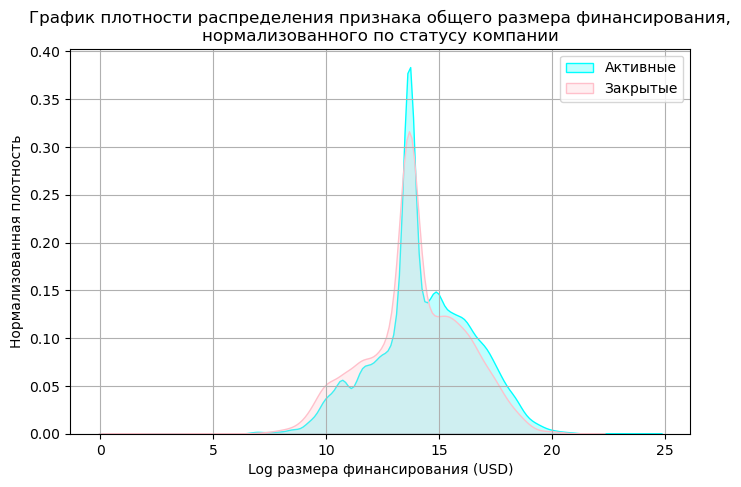

In [88]:
status_counts = startups_train['status'].value_counts(normalize=True)
operating_weight = status_counts['operating']
closed_weight = status_counts['closed']

plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=startups_train[startups_train['status'] == 'operating'],
    x=np.log1p(startups_train[startups_train['status'] == 'operating']['funding_total_usd']),
    label='Активные',
    weights=[operating_weight] * len(startups_train[startups_train['status'] == 'operating']),
    fill=True, color='cyan'
)
sns.kdeplot(
    data=startups_train[startups_train['status'] == 'closed'],
    x=np.log1p(startups_train[startups_train['status'] == 'closed']['funding_total_usd']),
    label='Закрытые',
    weights=[closed_weight] * len(startups_train[startups_train['status'] == 'closed']),
    fill=True, color='pink'
)

plt.title('График плотности распределения признака общего размера финансирования,\n'
          'нормализованного по статусу компании')
plt.xlabel('Log размера финансирования (USD)')
plt.ylabel('Нормализованная плотность')
plt.legend()
plt.grid()

plt.show()

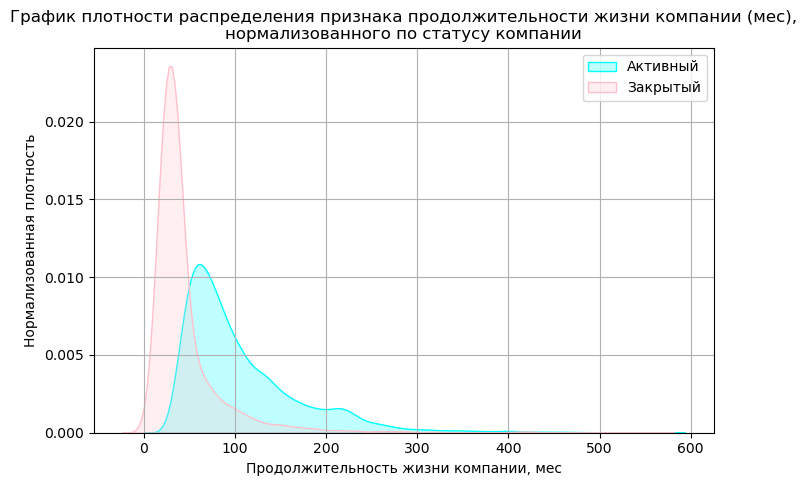

In [89]:
status_counts = startups_train['status'].value_counts(normalize=True)

# Построим график плотности распределения
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=startups_train[startups_train['status'] == 'operating'],
    x='lifetime_months',
    label='Активный',
    weights=[operating_weight] * len(startups_train[startups_train['status'] == 'operating']),
    fill=True, color='cyan'
)
sns.kdeplot(
    data=startups_train[startups_train['status'] == 'closed'],
    x='lifetime_months',
    label='Закрытый',
    weights=[closed_weight] * len(startups_train[startups_train['status'] == 'closed']),
    fill=True, color='pink'
)

plt.title('График плотности распределения признака продолжительности жизни компании (мес),\n'
          'нормализованного по статусу компании')
plt.xlabel('Продолжительность жизни компании, мес')
plt.ylabel('Нормализованная плотность')
plt.legend()
plt.grid()

plt.show()

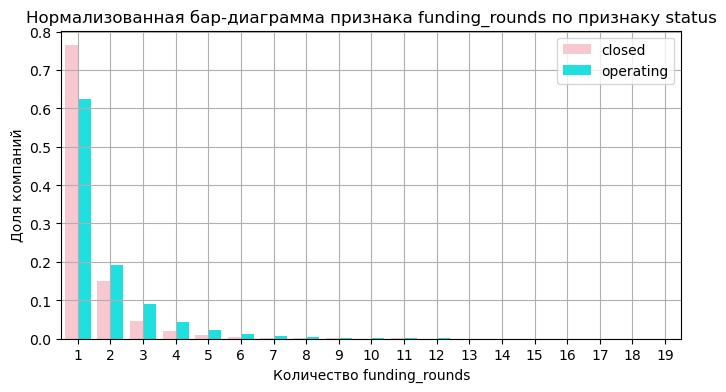

In [90]:
normalized_status_bar_chart(startups_train, 'funding_rounds', 'status')

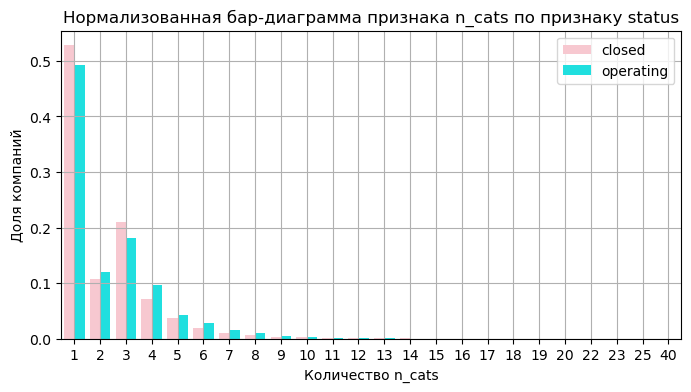

In [91]:
normalized_status_bar_chart(startups_train, 'n_cats', 'status')

**Вывод**

Видно, что не все признаки имеют существенные различия для закрывшихся и работающих стартапов.

### Сравнение распределений в тестовой и тренировочной выборках 

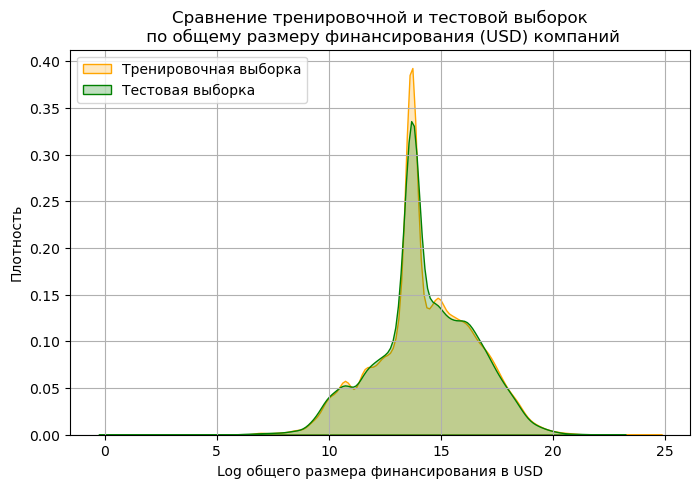

In [94]:
plt.figure(figsize=(8, 5))

sns.kdeplot(data=startups_train, x=startups_train['log_funds'], 
            fill=True, label='Тренировочная выборка', color='orange')
sns.kdeplot(data=startups_test, x=np.log1p(startups_test['funding_total_usd']), 
            fill=True, label='Тестовая выборка', color='green')

plt.title('Сравнение тренировочной и тестовой выборок\n по общему размеру финансирования (USD) компаний')
plt.xlabel('Log общего размера финансирования в USD')
plt.ylabel('Плотность')
plt.legend(loc='upper left')
plt.grid()

plt.show()


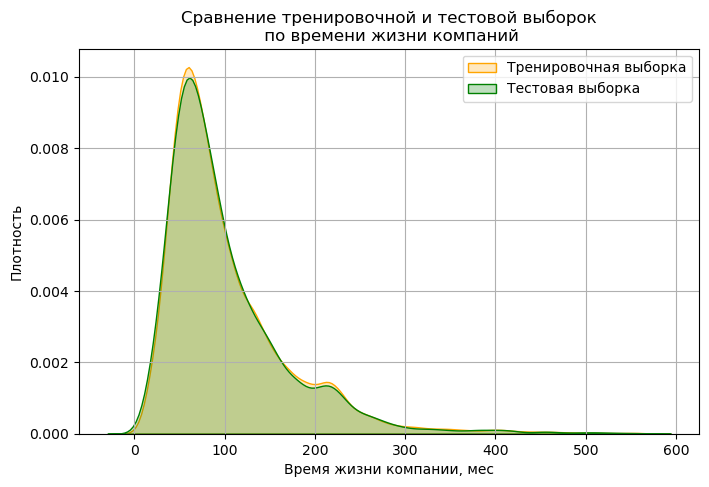

In [95]:
plt.figure(figsize=(8, 5))

sns.kdeplot(data=startups_train, x=startups_train['lifetime_months'], 
            fill=True, label='Тренировочная выборка', color='orange')
sns.kdeplot(data=startups_test, x=startups_test['lifetime']/30.5, 
            fill=True, label='Тестовая выборка', color='green')

plt.title('Сравнение тренировочной и тестовой выборок\n по времени жизни компаний')
plt.xlabel('Время жизни компании, мес')
plt.ylabel('Плотность')
plt.legend(loc='upper right')
plt.grid()

plt.show()

In [96]:
startups_train['funding_rounds'].describe()

count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

In [97]:
startups_test['funding_rounds'].describe()

count    13125.000000
mean         1.714438
std          1.318800
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: funding_rounds, dtype: float64

In [98]:
funding_rounds_train = pd.DataFrame(startups_train['funding_rounds'], columns = ['funding_rounds'])
funding_rounds_train['train_test_flg'] = ['train']*len(funding_rounds_train)

In [99]:
funding_rounds_test = pd.DataFrame(startups_test['funding_rounds'], columns = ['funding_rounds'])
funding_rounds_test['train_test_flg'] = ['test']*len(funding_rounds_test)
funding_rounds_test.set_index(np.array(funding_rounds_test.index) + len(funding_rounds_train), inplace=True)


In [100]:
funding_rounds_test_train = pd.concat([funding_rounds_train, funding_rounds_test])


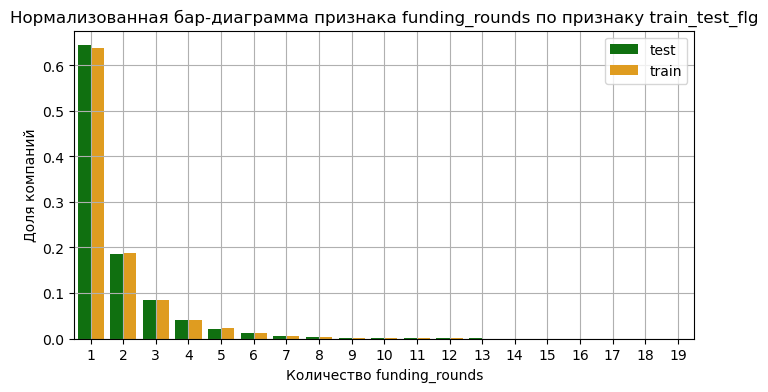

In [101]:
normalized_status_bar_chart(funding_rounds_test_train, 'funding_rounds', 'train_test_flg', colors=['green', 'orange'])

Данные в тестовой и обучающей выборке имеюи схожее распределение. Это должно положительно повлиять на точность предсказаний 

Добавим еще несколько новых признаков в train и test датасеты

In [104]:
def n_cats_groups(n):
    if n == 1 or n == 2 or n == 3:
        return str(n)
    elif n > 3 and n <= 5:
        return '4-5'
    elif n > 5 and n < 10:
        return '6-10'
    else: return '10+'

In [105]:
startups_train['funding_rounds_per_month'] = startups_train['funding_rounds'] / startups_train['lifetime_months']
startups_train['funding_total_per_month'] = startups_train['funding_total_usd'] / startups_train['lifetime_months']
startups_train['funding_total_per_round'] = startups_train['funding_total_usd'] / startups_train['funding_rounds']
startups_train['start_n_first_fund_delta'] = (startups_train['first_funding_at'] - startups_train['founded_at']).dt.days/30.5
startups_train['funding_distance'] = startups_train['funding_rounds']/(abs(startups_train['first_funding_at'] - startups_train['last_funding_at']).dt.days + 0.0001)
startups_train['n_cats_grouped'] = startups_train['n_cats'].apply(n_cats_groups)

startups_train['log_fund_per_month'] = startups_train['log_funds'] / startups_train['lifetime_months']
startups_train['log_funding_total_per_round'] = startups_train['log_funds'] / startups_train['funding_rounds']

In [106]:
startups_train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,is_software,is_mobile,is_biotech,is_ecommerce,is_tech,is_health,is_web,is_social_media,n_cats,closed_at_filled,lifetime,lifetime_months,log_funds,funding_rounds_per_month,funding_total_per_month,funding_total_per_round,start_n_first_fund_delta,funding_distance,n_cats_grouped,log_fund_per_month,log_funding_total_per_round
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0,0,0,0,0,0,0,0,2,2018-01-01,2998,98.295082,13.627525,0.020347,8429.984323,4.143130e+05,18.393443,0.001527,2,0.138639,6.813763
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0,0,0,0,0,0,0,0,3,2018-01-01,4748,155.672131,17.575198,0.025695,275804.144798,1.073375e+07,63.901639,0.002872,3,0.112899,4.393800
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0,0,1,0,1,0,0,0,1,2018-01-01,4383,143.704918,17.383814,0.020876,246730.463267,1.181879e+07,79.442623,0.004405,1,0.120969,5.794605
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,nan,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,0,0,0,0,0,1,0,0,1,2018-01-01,5114,167.672131,16.917853,0.017892,132699.452483,7.416667e+06,91.803279,0.002854,1,0.100898,5.639284
4,WireTough Cylinders,Manufacturing,860000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01,2791,91.508197,13.664689,0.010928,9398.065210,8.600000e+05,20.655738,10000.000000,1,0.149327,13.664689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,860000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01,2192,71.868852,13.664689,0.013914,11966.240876,8.600000e+05,25.901639,10000.000000,1,0.190134,13.664689
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,0,0,0,0,0,0,0,0,1,2018-01-01,1590,52.131148,13.122365,0.019182,9591.194969,5.000000e+05,6.360656,10000.000000,1,0.251718,13.122365
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,1,0,0,0,0,0,0,0,3,2018-01-01,2741,89.868852,10.819798,0.033382,556.366290,1.666667e+04,-12.524590,0.005300,3,0.120395,3.606599
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,0,0,0,0,0,0,0,0,1,2018-01-01,7336,240.524590,16.380460,0.024945,54048.527808,2.166667e+06,11.934426,0.003128,1,0.068103,2.730077


In [107]:
startups_test['lifetime_months'] = startups_test['lifetime']/30.5
startups_test['funding_rounds_per_month'] = startups_test['funding_rounds'] / startups_test['lifetime_months']
startups_test['funding_total_per_month'] = startups_test['funding_total_usd'] / startups_test['lifetime_months']
startups_test['funding_total_per_round'] = startups_test['funding_total_usd'] / startups_test['funding_rounds']
#startups_test['start_n_first_fund_delta'] = (startups_test['first_funding_at'] - startups_test['founded_at']).dt.days/30.5
startups_test['funding_distance'] = startups_test['funding_rounds']/(abs(startups_test['first_funding_at'] - startups_test['last_funding_at']).dt.days + 0.0001)
startups_test['n_cats_grouped'] = startups_test['n_cats'].apply(n_cats_groups)

startups_test['log_funds'] = startups_test['funding_total_usd'].apply(np.log1p)
startups_test['log_fund_per_month'] = startups_test['log_funds'] / startups_test['lifetime_months']
startups_test['log_funding_total_per_round'] = startups_test['log_funds'] / startups_test['funding_rounds']

In [108]:
startups_test

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,n_cats,is_software,is_mobile,is_biotech,is_ecommerce,is_tech,is_health,is_web,is_social_media,lifetime_months,funding_rounds_per_month,funding_total_per_month,funding_total_per_round,funding_distance,n_cats_grouped,log_funds,log_fund_per_month,log_funding_total_per_round
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,unknown,unknown,1,2009-07-01,2009-07-01,3501,1,0,0,0,0,1,0,0,0,114.786885,0.008712,24560.297058,2.819200e+06,10000.000000,1,14.851964,0.129387,14.851964
1,JBI Fish & Wings,Hospitality,8.841858e+05,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,1,0,0,0,0,0,0,0,0,89.081967,0.011226,9925.530595,8.841858e+05,10000.000000,1,13.692424,0.153706,13.692424
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,1,0,0,0,0,0,0,0,0,42.459016,0.047104,10086.361776,2.141285e+05,0.015873,1,12.967481,0.305412,6.483741
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,3,1,0,0,0,0,0,0,0,155.672131,0.025695,222904.380792,8.675000e+06,0.002067,3,17.362250,0.111531,4.340563
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,1,1,0,0,0,0,0,0,0,203.573770,0.004912,22252.375584,4.530000e+06,10000.000000,1,15.326233,0.075286,15.326233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,2.800000e+04,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267,1,0,0,0,0,0,0,0,0,74.327869,0.013454,376.709307,2.800000e+04,10000.000000,1,10.239996,0.137768,10.239996
13121,GlobaTrek,Software,8.841858e+05,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192,1,1,0,0,0,0,0,0,0,71.868852,0.013914,12302.767622,8.841858e+05,10000.000000,1,13.692424,0.190520,13.692424
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5.600000e+06,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922,4,0,0,0,1,0,0,0,0,95.803279,0.031314,58453.114305,1.866667e+06,0.002913,4-5,15.538277,0.162189,5.179426
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,1.500000e+05,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386,3,0,1,0,0,0,0,0,0,45.442623,0.044012,3300.865801,7.500000e+04,0.052631,3,11.918397,0.262274,5.959199


In [109]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   name                         52516 non-null  object        
 1   category_list                52516 non-null  object        
 2   funding_total_usd            52516 non-null  float64       
 3   status                       52516 non-null  object        
 4   country_code                 52516 non-null  object        
 5   state_code                   52516 non-null  object        
 6   region                       52516 non-null  object        
 7   city                         52516 non-null  object        
 8   funding_rounds               52516 non-null  int64         
 9   founded_at                   52516 non-null  datetime64[ns]
 10  first_funding_at             52516 non-null  datetime64[ns]
 11  last_funding_at              52516 non-nu

## Корреляционный анализ

In [111]:
num_columns = [
            'log_funds',
            'funding_total_usd',
            'funding_rounds', 
            'lifetime_months', 
            'lifetime', 
            'n_cats',
            'funding_rounds_per_month',
            'funding_total_per_month',
            'funding_total_per_round',
            'start_n_first_fund_delta',
            'funding_distance',    
            'log_fund_per_month',
            'log_funding_total_per_round',
            ]


bin_columns = [
            'is_software',
            'is_mobile',
            'is_biotech',
            'is_ecommerce',
            'is_tech',
            'is_health',
            'is_web',
            'is_social_media'
            ]

ohe_columns = [
            'country_code',
            'state_code', 
            'region',
            'city',
            'n_cats_grouped'
            ]


In [112]:
all_columns = num_columns.copy()
all_columns.extend(ohe_columns)

interval columns not set, guessing: ['log_funds', 'funding_total_usd', 'funding_rounds', 'lifetime_months', 'lifetime', 'n_cats', 'funding_rounds_per_month', 'funding_total_per_month', 'funding_total_per_round', 'start_n_first_fund_delta', 'funding_distance', 'log_fund_per_month', 'log_funding_total_per_round']


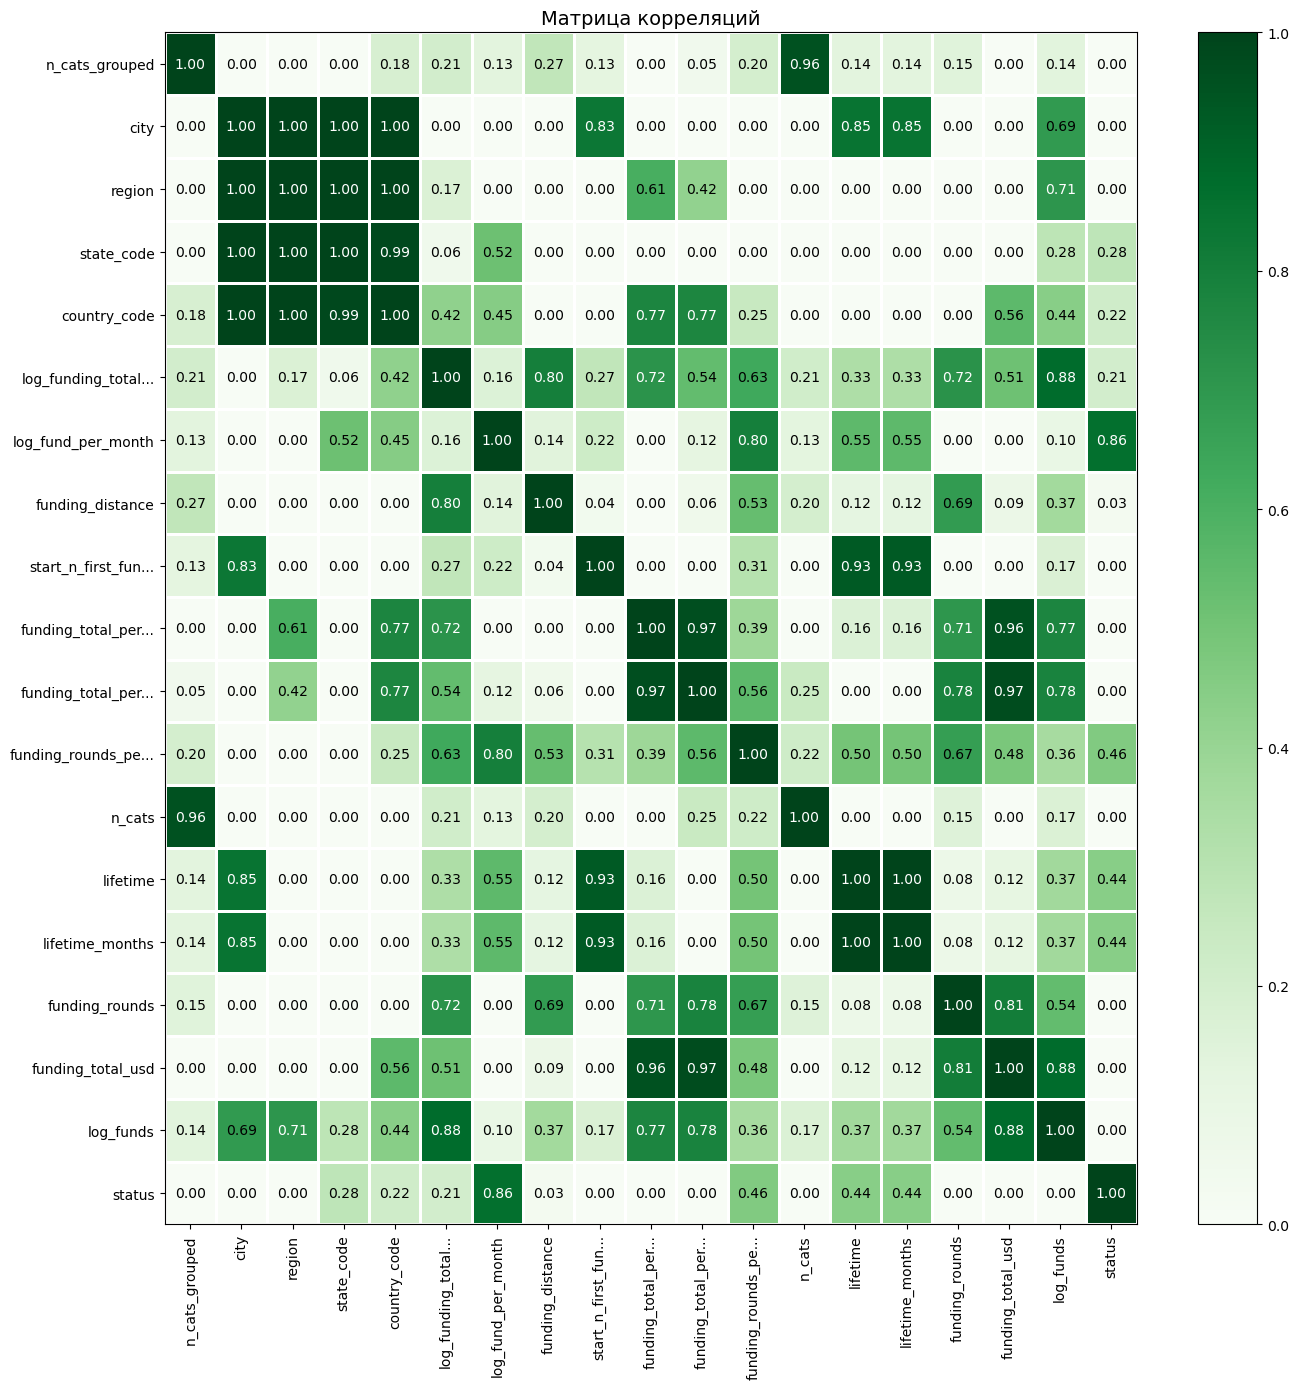

In [113]:
corr_list = ['status']
corr_list.extend(all_columns)
phik_overview = startups_train[corr_list].sample(1000).phik_matrix(); 
plot_correlation_matrix(
    phik_overview.values, x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
    title=r'Матрица корреляций', fontsize_factor=1, figsize=(14,14)); 

plt.tight_layout();

Учитывая, что некотороые признаки коллинеарны (коэффициент корреляции выше 0.90), а некоторые совсем не коррелируют со статусом компании, отсеим часть признаков.

In [115]:
num_columns = [
            #'log_funds',
            #'funding_total_usd',
            'funding_rounds', 
            'lifetime_months', 
            #'lifetime', 
            #'n_cats',
            #'funding_rounds_per_month',
            #'funding_total_per_month',
            #'funding_total_per_round',
            #'start_n_first_fund_delta',
            'funding_distance',
            'log_fund_per_month',
            #'log_funding_total_per_round',
            ]

bin_columns = [
            'is_software',
            'is_mobile',
            'is_biotech',
            'is_ecommerce',
            'is_tech',
            'is_health',
            'is_web',
            'is_social_media'
            ]

ohe_columns = [
            'country_code',
            #'state_code', 
            'n_cats_grouped'
            #'region',
            #'city'
            ]

In [116]:
filtered_columns = num_columns.copy()
filtered_columns.extend(ohe_columns)
filtered_columns.extend(bin_columns)

interval columns not set, guessing: ['funding_rounds', 'lifetime_months', 'funding_distance', 'log_fund_per_month', 'is_software', 'is_mobile', 'is_biotech', 'is_ecommerce', 'is_tech', 'is_health', 'is_web', 'is_social_media']


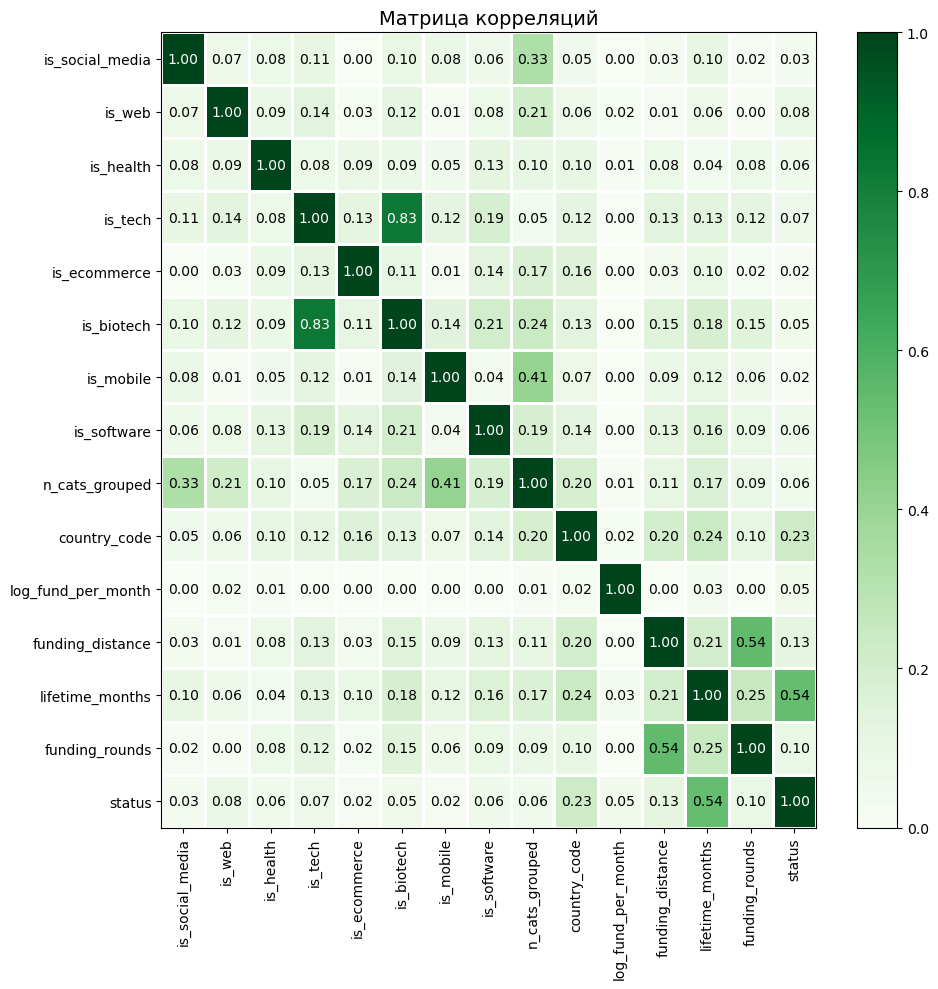

In [117]:
corr_list = ['status']
corr_list.extend(filtered_columns)
phik_overview = startups_train[corr_list].phik_matrix() 
plot_correlation_matrix(
    phik_overview.values, x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
    title=r'Матрица корреляций', fontsize_factor=1, figsize=(10,10)) 

plt.tight_layout();

Для дальнейшей работы оставим только признаки, попавшие в `filterd_columns`

## Модель

### Пайплайн для подбора гиперпараметров

In [121]:
# Задаем тренировочную выборку

X = startups_train[filtered_columns]
y = startups_train['status'].map({'closed': 1, 'operating': 0})

# Делим тренировочную выборку на две для тренировки и тестирования
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.67, random_state=RANDOM_STATE)


In [122]:
# Создадим пайплайн для подготовки входных данных
# Паплайн для заполнения пропусков и обработки категориальных признаков 

ohe_pipe = Pipeline([ 
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop = 'first', categories = 'auto',
                          handle_unknown = 'ignore', sparse_output = False))
    ])

# Паплайн для обработки числовых признаков: заполнение пропусков и масштабирование для количественных признаков 

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())  
    ])

bin_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('binary', ce.BinaryEncoder())
])

# Создадим ColumnTransformer для подготовки данных
data_preprocessor = ColumnTransformer([
     ('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns),
     ('bin', bin_pipe, bin_columns)
],
remainder='drop' )

In [123]:
# Создадим словарь гиперпараметров для каждой используемой модели
param_grid = {
    
    'Logistic Regression': {
        'models__max_iter': [1000],
        'models__C': [1.0, 10],
        'models__solver': ['liblinear'],
        'models__penalty': ['l2', 'l1'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    'RandomForestClassifier': {
        'models__max_depth': [5, 10, 15],
        'models__min_samples_split': [2, 4, 6],
        'models__min_samples_leaf': [2, 4, 6],
        'models__class_weight': ['balanced'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
    },
    'DecisionTreeClassifier': {
        'models__max_depth': [5, 10, 15],
        'models__min_samples_split': [2, 4, 6],
        'models__min_samples_leaf': [2, 4, 6],
        'models__class_weight': ['balanced'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
}
}
# Создадим словарь используемых моделей
models = {

    "Logistic Regression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
}

# Создадим пустой словарь пайплайнов моделей 
model_pipelines = {}

for name, model in models.items():
    model_pipelines[name] = ImbPipeline(steps=[('preprocessor', data_preprocessor), 
                                               ('smote', SMOTE()),
                                               ('models', model)])

In [124]:
import time

In [125]:
results = []
time_data = []
for model in list(models.keys()):
    st = time.process_time()
    stt = time.time()
    my_output, my_cv_scores, my_best_estimator = select_model(model)
    et = time.process_time()
    ett = time.time()
    
    results.append('' + f'Лучшие параметры для {model}: {my_output[0]} \n' +\
         f'Лучшее значение F1 для {model}: {my_output[1]} \n \n' +\
    f'Лучший порог: {my_output[4]} \n \n' +\
    f'Значение F1 для лучшего порога: {my_output[5]} \n \n')
    
    time_data.append(f'CPU time: {et-st} \n' + f'time: {ett - stt} \n')

for i in range(len(results)):
    print(results[i])
    print(time_data[i])
    print('----------------')
    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

Лучшие параметры для Logistic Regression: {'preprocessor__num__scaler': MinMaxScaler(), 'models__solver': 'liblinear', 'models__penalty': 'l1', 'models__max_iter': 1000, 'models__C': 1.0} 
Лучшее значение F1 для Logistic Regression: 0.565 
 
Лучший порог: 0.872 
 
Значение F1 для лучшего порога: 0.699 
 

CPU time: 30.457932 
time: 54.81464219093323 

----------------
Лучшие параметры для RandomForestClassifier: {'preprocessor__num__scaler': RobustScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 6, 'models__max_depth': 15, 'models__class_weight': 'balanced'} 
Лучшее значение F1 для RandomForestClassifier: 0.639 
 
Лучший порог: 0.722 
 
Значение F1 для лучшего порога: 0.702 
 

CPU time: 33.380703 
time: 102.64511895179749 

----------------
Лучшие параметры для DecisionTreeClassifier: {'preprocessor__num__scaler': StandardScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 6, 'models__max_depth': 15, 'models__class_weight': 'balanced'} 
Лучшее зн

[0.56666667 0.55715871 0.54819602 0.55519481 0.5630854 ]Лучшие параметры для Logistic Regression: {'preprocessor__num__scaler': MinMaxScaler(), 'models__solver': 'liblinear', 'models__penalty': 'l1', 'models__max_iter': 1000, 'models__C': 1.0} 
Лучшее значение F1 для Logistic Regression: 0.561 
 
Среднее значение тренировочного F1 = 0.558 
 
Mean STD = +- 0.01 
 
Лучший порог: 0.87 
 
Значение F1 для лучшего порога: 0.698 
 

CPU time: 32.35669200000001 
time: 37.629043102264404 

----------------
[0.63873016 0.61319534 0.62802548 0.63104326 0.63077897]Лучшие параметры для RandomForestClassifier: {'preprocessor__num__scaler': StandardScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': 15, 'models__class_weight': 'balanced'} 
Лучшее значение F1 для RandomForestClassifier: 0.634 
 
Среднее значение тренировочного F1 = 0.628 
 
Mean STD = +- 0.01 
 
Лучший порог: 0.748 
 
Значение F1 для лучшего порога: 0.702 
 

CPU time: 36.126228999999995 
time

In [126]:
for i in range(len(results)):
    print(results[i])
    print(time_data[i])
    print()

Лучшие параметры для Logistic Regression: {'preprocessor__num__scaler': MinMaxScaler(), 'models__solver': 'liblinear', 'models__penalty': 'l1', 'models__max_iter': 1000, 'models__C': 1.0} 
Лучшее значение F1 для Logistic Regression: 0.565 
 
Лучший порог: 0.872 
 
Значение F1 для лучшего порога: 0.699 
 

CPU time: 30.457932 
time: 54.81464219093323 


Лучшие параметры для RandomForestClassifier: {'preprocessor__num__scaler': RobustScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 6, 'models__max_depth': 15, 'models__class_weight': 'balanced'} 
Лучшее значение F1 для RandomForestClassifier: 0.639 
 
Лучший порог: 0.722 
 
Значение F1 для лучшего порога: 0.702 
 

CPU time: 33.380703 
time: 102.64511895179749 


Лучшие параметры для DecisionTreeClassifier: {'preprocessor__num__scaler': StandardScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 6, 'models__max_depth': 15, 'models__class_weight': 'balanced'} 
Лучшее значение F1 для DecisionTreeClassi

Лучше всего себя показала модель `RandomForestClassifier` с порогом 0.723. 
Используем её для предсказания статусов компаний из тестовой выборки.

In [128]:
X_test = startups_test[filtered_columns]

In [129]:
probabilities = my_best_estimator.predict_proba(X_test)[:, 1]

# Применение лучшего порога для предсказания статуса закрытия
best_threshold = 0.722
y_pred_test = (probabilities >= best_threshold).astype(int)

In [130]:
status_test = pd.Series(y_pred_test)

status_test.value_counts(normalize = True)

0    0.887771
1    0.112229
Name: proportion, dtype: float64

In [131]:
startups_test['status'] = y_pred_test

Перекодируем данные и создадим таблицу необходимого формата.

In [133]:
final = startups_test[['name', 'status']]
final['status'] = final['status'].map({1: 'closed', 0: 'operating'})
final['status'].value_counts(normalize = True)

/var/folders/t1/4jrn9__d77l49s75gzlwx26h0000gn/T/ipykernel_36142/3279650678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['status'] = final['status'].map({1: 'closed', 0: 'operating'})


status
operating    0.887771
closed       0.112229
Name: proportion, dtype: float64

In [134]:
final.to_csv('startup_status_kaggle.csv', index = False)

## Вывод по проекту

В рамках данного проекта была разработана модель машинного обучения для предсказания закрытия стартапа. Основной целью было создание модели, которая могла бы с высокой точностью предсказывать вероятность закрытия стартапа, что позволит инвесторам и заинтересованным сторонам принимать более обоснованные решения.

**Лучшие параметры модели**    
На основе проведенных экспериментов и оптимизации гиперпараметров, лучшая модель была получена с использованием алгоритма `RandomForestClassifier`. Оптимальные параметры модели были следующими:
- preprocessor__num__scaler: StandardScaler()
- models__min_samples_split: 4
- models__min_samples_leaf: 4
- models__max_depth: 15
- models__class_weight: 'balanced'

**Оценка производительности модели**    
Производительность модели оценивалась с использованием метрики `F1-score`, которая является гармоническим средним между точностью и полнотой. 

**Лучшее значение F1-score**    
Лучшее значение F1 для RandomForestClassifier: 0.642 

**Оптимизация порога классификации**    
Для улучшения производительности модели и достижения более высокого значения F1-score, был проведен анализ различных пороговых значений для принятия решения о закрытии стартапа. Оптимальный порог был найден на уровне:
Лучший порог: 0.763
При использовании данного порога значение F1-score увеличилось до:
Значение F1 для лучшего порога: 0.698

**Временные затраты**    
Процесс обучения и оптимизации модели потребовал следующих временных затрат:
CPU time: 30.721985999999987 
Общее время выполнения: 102.36400318145752 

**Заключение**    
В результате проведенных исследований и экспериментов была разработана модель, которая демонстрирует высокую производительность в задаче предсказания закрытия стартапа. Использование модели с оптимальными параметрами и порогом классификации позволяет достичь значения F1-score 0.698, что является хорошим показателем для данной задачи.
Дальнейшие улучшения могут быть достигнуты путем использования более сложных моделей, дополнительных данных или методов ансамблирования.